In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

2024-04-09 15:44:32.837790: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-09 15:44:32.843548: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-09 15:44:32.907021: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 15:44:33.936849: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Set all the Constants

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/zuhaib-ashraf/Desktop/malnutrition/data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 398 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
class_names

['malnurised', 'normal']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1]


2024-04-08 13:51:51.486347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Visualize some of the images from our dataset

2024-04-08 13:51:53.073650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


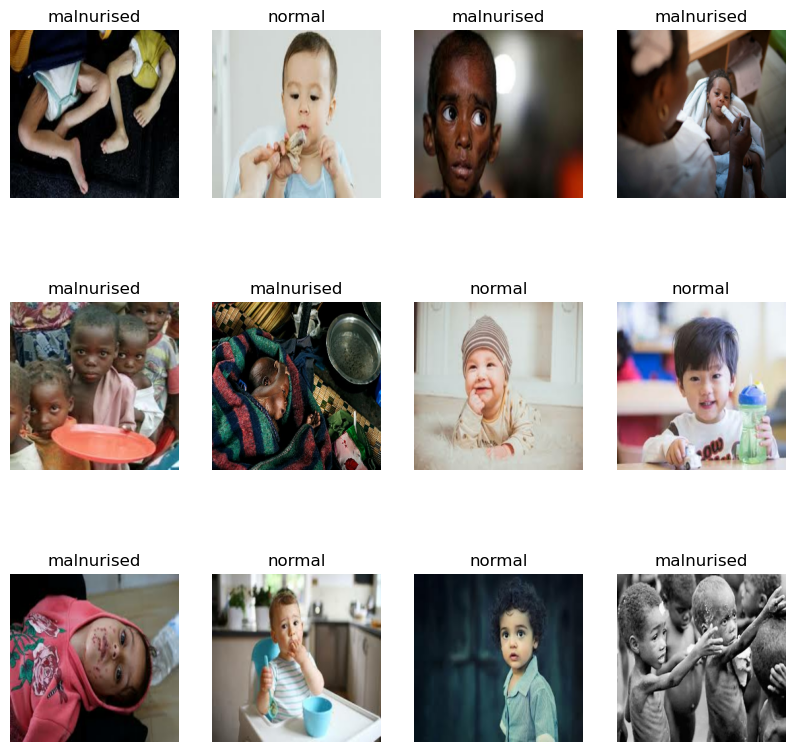

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [8]:
len(dataset)

13

In [9]:
train_size = 0.8
len(dataset)*train_size

10.4

In [10]:
train_ds = dataset.take(54)
len(train_ds)

13

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [12]:
val_size=0.1
len(dataset)*val_size

1.3

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

10

In [18]:
len(val_ds)

1

In [19]:
len(test_ds)

2

### Cache, Shuffle, and Prefetch the Dataset

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size.
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [26]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [27]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [28]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/home/zuhaib-ashraf/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [30]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 2)                │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,682 (717.51 KB)

 Trainable params: 183,682 (717.51 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


2024-04-08 13:54:39.831322: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264257536 exceeds 10% of free system memory.
2024-04-08 13:54:40.059179: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 128000000 exceeds 10% of free system memory.
2024-04-08 13:54:40.558130: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 128000000 exceeds 10% of free system memory.
2024-04-08 13:54:40.976242: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 132128768 exceeds 10% of free system memory.
2024-04-08 13:54:40.976353: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264257536 exceeds 10% of free system memory.


10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4684 - loss: 0.6975 - val_accuracy: 0.4688 - val_loss: 0.6708
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6167 - loss: 0.6395 - val_accuracy: 0.5938 - val_loss: 0.6438
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6411 - loss: 0.6206 - val_accuracy: 0.6562 - val_loss: 0.5542
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8061 - loss: 0.4628 - val_accuracy: 0.8125 - val_loss: 0.3841
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7779 - loss: 0.3927 - val_accuracy: 0.8750 - val_loss: 0.3342
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8181 - loss: 0.3914 - val_accuracy: 0.9062 - val_loss: 0.3551
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8510 - loss: 0.3204 - val_accuracy: 0.8750 - val_loss: 0.2758
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8636 - loss: 0.3143 - val_accuracy: 0.9062 - val_loss: 0.2790
Epo

In [33]:
scores = model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step - accuracy: 0.9792 - loss: 0.1085


**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [34]:
scores

[0.10282324254512787, 0.984375]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [35]:
history

In [36]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 10}

In [37]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [38]:
type(history.history['loss'])

list

In [39]:
len(history.history['loss'])

50

In [40]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.6956432461738586,
 0.6274008750915527,
 0.6084378957748413,
 0.4238964021205902,
 0.4125300347805023]

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

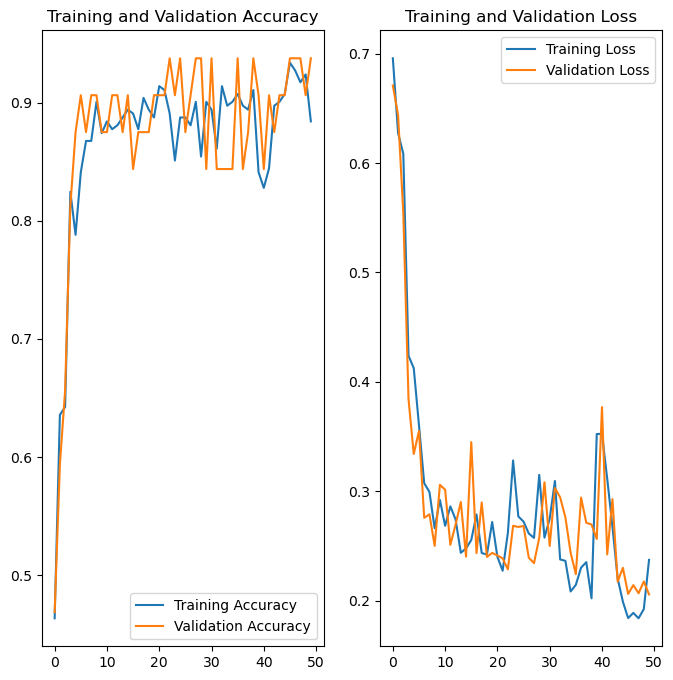

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
predicted label: normal


2024-04-08 14:07:24.947791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


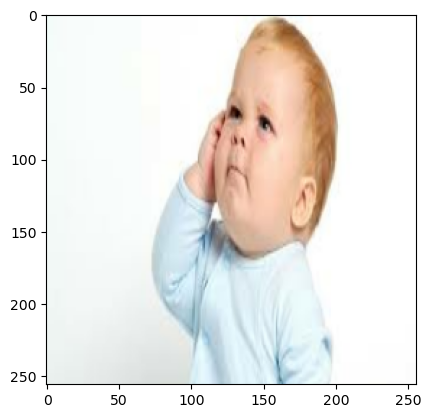

In [43]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


2024-04-08 14:07:33.298094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


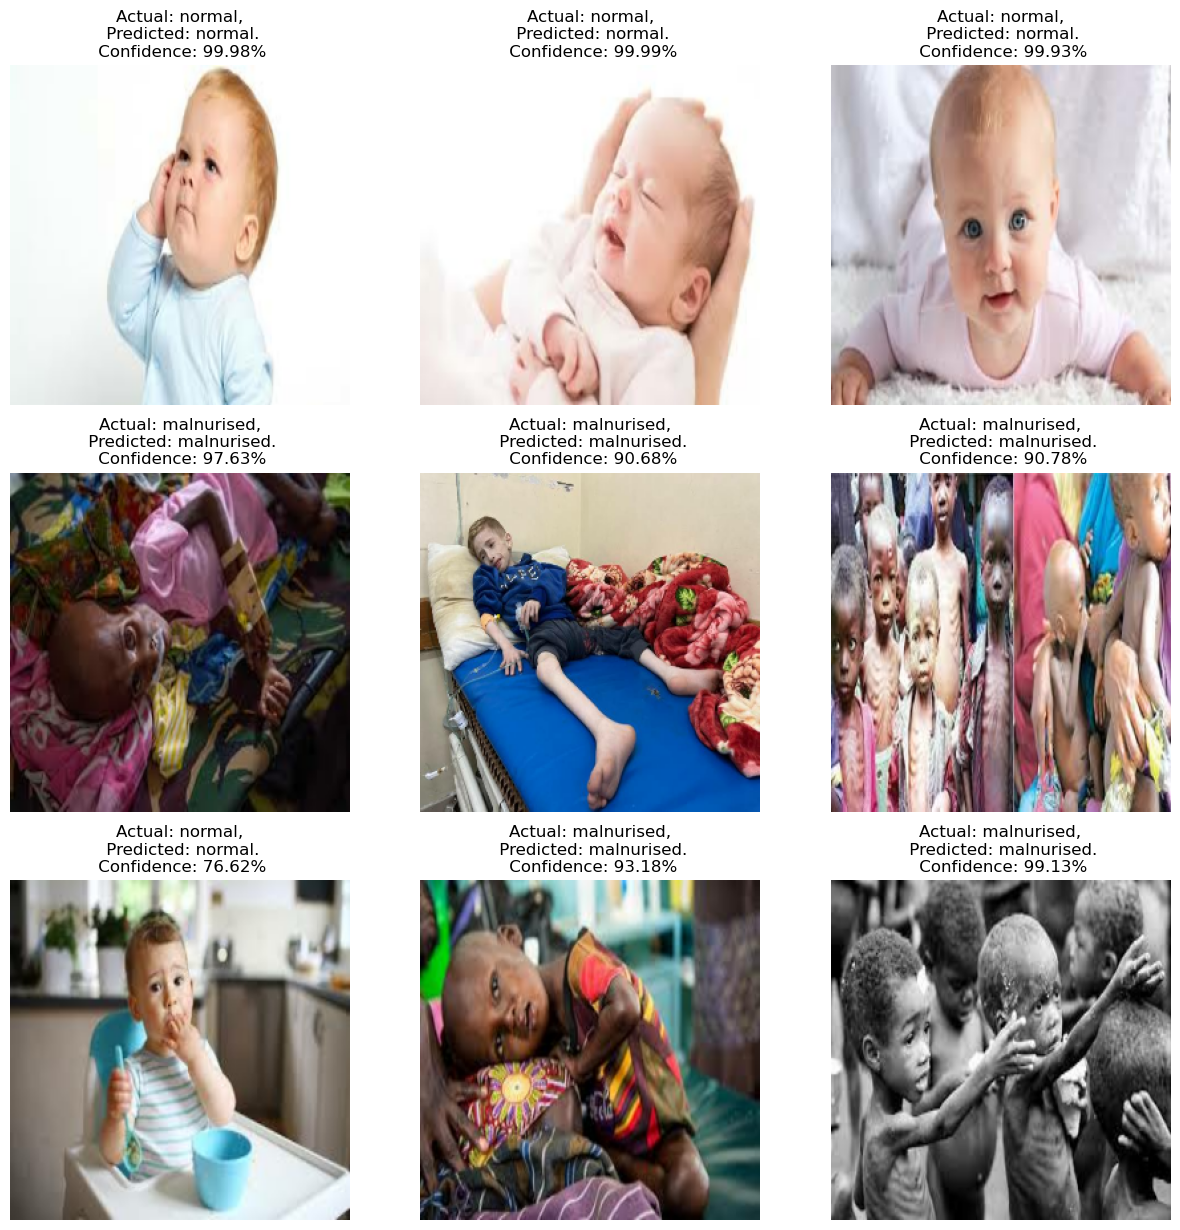

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [48]:
model.save("malnutrition_model.h5")

In [49]:
model.save("malnutrition_model.keras")